In [56]:
# !pip install teaching_tools


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [64]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay,classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV,cross_val_score,train_test_split
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import ipywidgets as widgets
from ipywidgets import interact
from teaching_tools.widgets import ConfusionMatrixWidget

In [2]:
data=pd.read_csv("poland_data.csv").set_index("company_id")

In [3]:
data.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,bankrupt
company_id,,,,,,,,,,,,,,,,,,,,,
1,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.12250,1.1961,0.46359,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,False
2,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.17210,1.6018,0.53962,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,False
3,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.98810,1.0077,0.67566,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,False
5,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.40940,1.3393,0.58496,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,False
6,0.182060,0.55615,0.32191,1.6045,16.3140,0.00000,0.182060,0.79808,1.8126,0.44385,...,0.555770,0.410190,0.46957,0.029421,8.4553,3.3488,107.240,3.4036,12.4540,False


## Explore

In [4]:
data.shape

(9977, 65)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9977 entries, 1 to 10503
Data columns (total 65 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feat_1    9977 non-null   float64
 1   feat_2    9977 non-null   float64
 2   feat_3    9977 non-null   float64
 3   feat_4    9960 non-null   float64
 4   feat_5    9952 non-null   float64
 5   feat_6    9977 non-null   float64
 6   feat_7    9977 non-null   float64
 7   feat_8    9964 non-null   float64
 8   feat_9    9974 non-null   float64
 9   feat_10   9977 non-null   float64
 10  feat_11   9977 non-null   float64
 11  feat_12   9960 non-null   float64
 12  feat_13   9935 non-null   float64
 13  feat_14   9977 non-null   float64
 14  feat_15   9970 non-null   float64
 15  feat_16   9964 non-null   float64
 16  feat_17   9964 non-null   float64
 17  feat_18   9977 non-null   float64
 18  feat_19   9935 non-null   float64
 19  feat_20   9935 non-null   float64
 20  feat_21   9205 non-null   flo

In [6]:
## checking class balance
data["bankrupt"].value_counts()

False    9510
True      467
Name: bankrupt, dtype: int64

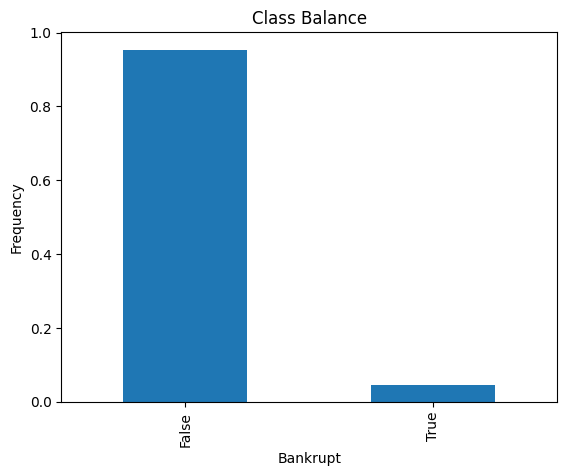

In [7]:
data["bankrupt"].value_counts(normalize=True).plot(
    kind="bar",
    xlabel="Bankrupt",
    ylabel="Frequency",
    title="Class Balance"
);

``Dataset is imbalanced the counts of negativve class is more than the positive class``

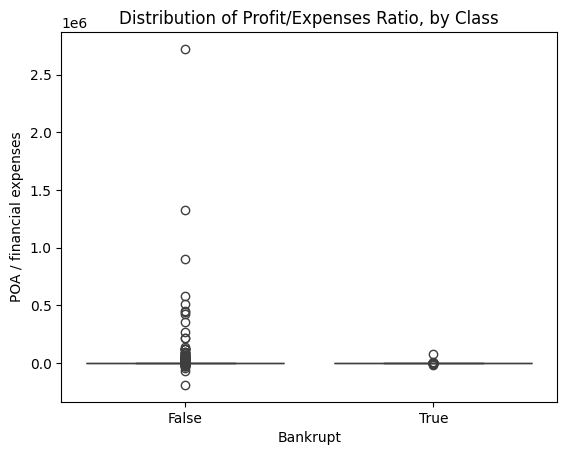

In [8]:
##we saw that there were 64 features of each company,
##each of which had some kind of numerical value.
##It might be useful to understand where the values for one of these features cluster, 
##so let's make a boxplot to see how the values in "feat_27" are distributed.
sns.boxplot(x="bankrupt",y="feat_27",data=data)
plt.xlabel("Bankrupt")
plt.ylabel("POA / financial expenses")
plt.title("Distribution of Profit/Expenses Ratio, by Class");

IT shows that the companies which are in the false class
(Not Going To Bankrupt) contains outliers which show that those companies are making a lot of profit

In [9]:
# Summary statistics for `feat_27`
data["feat_27"].describe().apply("{0:,.0f}".format)

count        9,312
mean         1,206
std         35,477
min       -190,130
25%              0
50%              1
75%              5
max      2,723,000
Name: feat_27, dtype: object

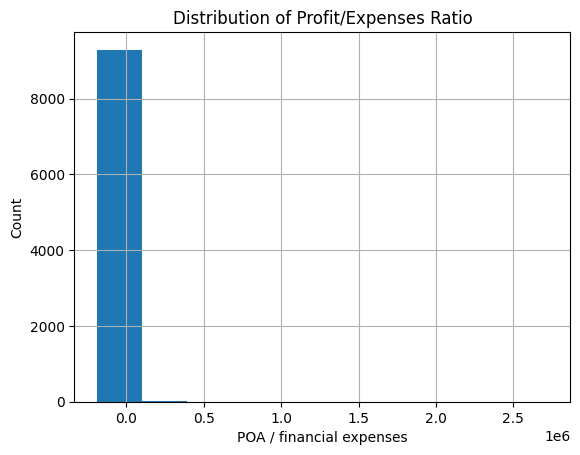

In [10]:
# Plot histogram of `feat_27`
data["feat_27"].hist()
plt.xlabel("POA / financial expenses")
plt.ylabel("Count"),
plt.title("Distribution of Profit/Expenses Ratio");

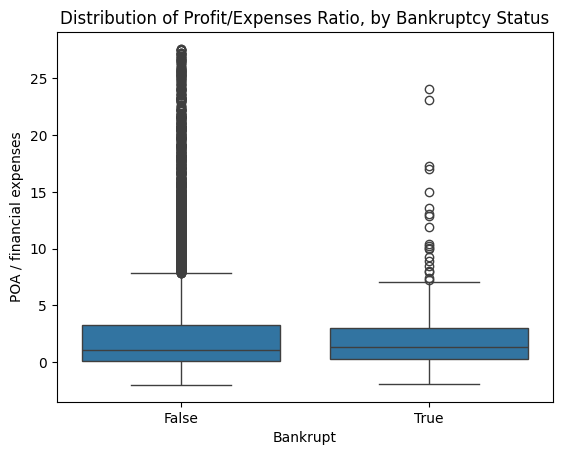

In [11]:
# Create clipped boxplot using the values for "feat_27" that fall
#between the 0.1 and 0.9 quantiles for the column.
q1,q9=data["feat_27"].quantile([0.1,0.9])
mask=data["feat_27"].between(q1,q9)
sns.boxplot(x="bankrupt",y="feat_27",data=data[mask])
plt.xlabel("Bankrupt")
plt.ylabel("POA / financial expenses")
plt.title("Distribution of Profit/Expenses Ratio, by Bankruptcy Status");

#### we have large amount of skewed data present in the dataset

<AxesSubplot: >

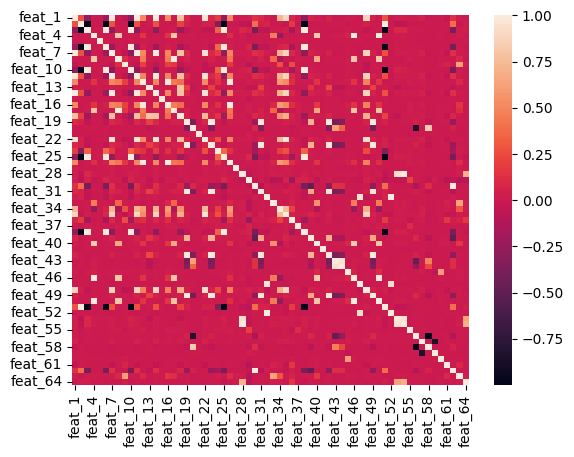

In [12]:
#plotting a correlation heatmap 
corr = data.drop(columns="bankrupt").corr()
sns.heatmap(corr)

### Learnings from the EDA
We have encountered several challenges during our data analysis process that require careful consideration and strategic planning. Firstly, our data exhibits an imbalance, which is a common issue in many datasets. Addressing this imbalance will be a crucial aspect of our data preparation phase to ensure that our model can generalize well to both classes.

Secondly, a significant number of features in our dataset have missing values, necessitating an imputation strategy. Given the high skewness of these features, opting for the median as the imputation technique seems more appropriate than using the mean, which could be sensitive to outliers and skewness.

Furthermore, we have identified autocorrelation issues within our data, indicating a potential violation of the independence assumption in linear models. To mitigate this, we plan to steer clear of linear models and explore tree-based models, which are more robust to autocorrelation and can capture nonlinear relationships effectively.

By addressing these challenges proactively and employing suitable strategies, we aim to build a reliable and accurate predictive model 

# Split

In [13]:
target = "bankrupt"
X = data.drop(columns=target)
y = data[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (9977, 64)
y shape: (9977,)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7981, 64)
y_train shape: (7981,)
X_test shape: (1996, 64)
y_test shape: (1996,)


# Resample
Since our data is completely inbalanced many Resamplinng techniques are used to make the data balanced to fit into the model                                                   
(i) Under_Sampling                                           
When data is imbalanced in different classes, one way we can balance it is reducing the number of observations in the majority class. This is called under-sampling.
(ii) Over_Sampling                                           
Over-sampling is the opposite of under-sampling. Instead of reducing the majority class, over-sampling increases the number of observations in the minority class by randomly making copies of the existing observations

In [15]:
## Performing Under Sampling
under_sampler =RandomUnderSampler(random_state=42)
X_train_under, y_train_under =under_sampler.fit_resample(X_train,y_train)
print(X_train_under.shape)
X_train_under.head()

(768, 64)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64
company_id,,,,,,,,,,,,,,,,,,,,,
1509,0.121400,0.097238,0.74500,8.66160,25.8370,0.000000,0.158840,9.284100,2.7588,0.902760,...,775.71,0.075999,0.13447,0.94243,0.000000,4.9049,11.3390,12.865,28.3720,17.4870
6096,0.316280,0.264920,0.65346,3.46660,55.1890,0.290140,0.316280,2.774700,2.4721,0.735080,...,1367.90,0.119990,0.43027,0.87412,0.000000,10.6020,4.5533,39.115,9.3314,30.2870
7369,0.066615,0.890270,-0.48007,0.46076,-76.3080,0.047487,0.087936,-0.011406,1.0952,-0.010155,...,-46566.00,0.086894,-6.56010,0.91311,0.000000,32.0280,10.0480,105.220,3.4689,5.2362
5268,0.208000,0.363630,0.33875,1.93160,-5.3169,0.251870,0.258280,1.603300,1.0535,0.583020,...,187050.00,0.050746,0.35676,0.94925,0.000000,34.8840,19.0030,24.498,14.8990,18.2040
395,0.096863,0.299320,0.35393,2.42640,31.5630,0.267550,0.125130,2.341000,1.0495,0.700680,...,2993.00,0.047123,0.13824,0.95288,0.073041,13.7820,6.8621,39.668,9.2013,5.7376


In [16]:
y_train_under.value_counts(normalize=True)

False    0.5
True     0.5
Name: bankrupt, dtype: float64

In [17]:
##Performing Over Sampling
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over =over_sampler.fit_resample(X_train,y_train)
print(X_train_over.shape)
X_train_over.head()

(15194, 64)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64
0,0.279320,0.053105,0.852030,17.0440,199.080,0.741770,0.353570,16.00600,1.2346,0.84997,...,52857.00,0.190040,0.328630,0.80996,0.00000,NaN,4.1858,11.002,33.1760,18.5720
1,0.001871,0.735120,0.156460,1.2269,-10.837,0.000000,0.002938,0.36032,1.4809,0.26488,...,440.02,0.014794,0.007064,0.99803,0.00000,7.4268,2.2925,169.960,2.1476,9.6185
2,0.113940,0.490250,0.077121,1.2332,-43.184,-0.000171,0.113940,1.03980,1.1649,0.50975,...,4617.40,0.214890,0.223520,0.78761,0.27412,6.2791,6.1622,103.630,3.5220,1.9673
3,0.008136,0.652610,0.148120,1.2628,29.071,0.000000,0.008136,0.53230,1.2891,0.34739,...,920.98,0.045169,0.023421,0.99434,0.14403,22.7480,2.2673,159.580,2.2872,4.4718
4,0.045396,0.279640,0.708730,3.7656,238.120,0.000000,0.056710,2.57610,1.0169,0.72036,...,10744.00,0.047501,0.063019,0.94624,0.00000,13.8860,49.0660,91.984,3.9681,29.0460


In [18]:
y_train_over.value_counts(normalize=True)

False    0.5
True     0.5
Name: bankrupt, dtype: float64

#### Now We get the balanced data by performing the Resampling Techniques

# Build Model

### Baseline Of Model

In [19]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9519


Because our classes are imbalanced, the baseline accuracy is very high. We should keep this in mind because, even if our trained model gets a high validation accuracy score, that doesn't mean it's actually good.

## 1.Decision Tree Classifier
Train the model on different data Normal data and undersampled and oversampled data

In [20]:
# Fit on `X_train`, `y_train`
model_reg = make_pipeline(
SimpleImputer(strategy="median"),
DecisionTreeClassifier(random_state=42)
)
model_reg.fit(X_train,y_train)

# Fit on `X_train_under`, `y_train_under`
model_under = make_pipeline(
SimpleImputer(strategy="median"),
DecisionTreeClassifier(random_state=42)
)
model_under.fit(X_train_under,y_train_under)

# Fit on `X_train_over`, `y_train_over`
model_over = make_pipeline(
SimpleImputer(strategy="median"),
DecisionTreeClassifier(random_state=42)
)
model_over.fit(X_train_over,y_train_over)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

### Evaluate
Checking the Accuracy of three models trained on different Data

In [21]:
for m in [model_reg, model_under, model_over]:
    acc_train = m.score(X_train,y_train)
    acc_test = m.score(X_test,y_test)
    print("Training Accuracy:", round(acc_train, 4))
    print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 1.0
Test Accuracy: 0.9359
Training Accuracy: 0.7421
Test Accuracy: 0.7104
Training Accuracy: 1.0
Test Accuracy: 0.9344


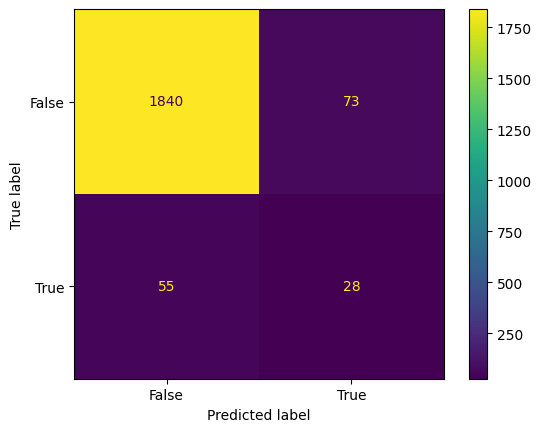

In [22]:
#Plot Confusion Matrix for model build on normal data
ConfusionMatrixDisplay.from_estimator(model_reg,X_test,y_test)

In [23]:
## Checking the Depth of the decision tree
depth = model_over.named_steps["decisiontreeclassifier"].get_depth()
print(depth)

33


### Communicate

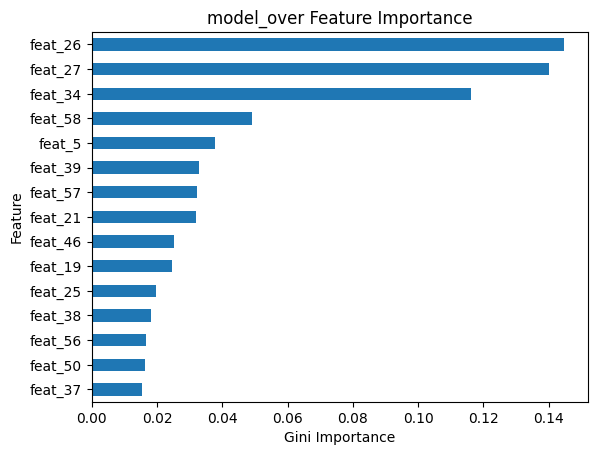

In [24]:
#a horizontal bar chart with the 15 most important features for model_over
# Get importances
importances = model_over.named_steps["decisiontreeclassifier"].feature_importances_

# Put importances into a Series
feat_imp =pd.Series(importances,index=X_train_over.columns).sort_values()

# Plot series
feat_imp.tail(15).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("model_over Feature Importance");

## 2. Random Forest Classifier

In [25]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7981, 64)
y_train shape: (7981,)
X_test shape: (1996, 64)
y_test shape: (1996,)


In [26]:
##Performing Over Sampling
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over =over_sampler.fit_resample(X_train,y_train)
print(X_train_over.shape)
X_train_over.head()

(15194, 64)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64
0,0.279320,0.053105,0.852030,17.0440,199.080,0.741770,0.353570,16.00600,1.2346,0.84997,...,52857.00,0.190040,0.328630,0.80996,0.00000,NaN,4.1858,11.002,33.1760,18.5720
1,0.001871,0.735120,0.156460,1.2269,-10.837,0.000000,0.002938,0.36032,1.4809,0.26488,...,440.02,0.014794,0.007064,0.99803,0.00000,7.4268,2.2925,169.960,2.1476,9.6185
2,0.113940,0.490250,0.077121,1.2332,-43.184,-0.000171,0.113940,1.03980,1.1649,0.50975,...,4617.40,0.214890,0.223520,0.78761,0.27412,6.2791,6.1622,103.630,3.5220,1.9673
3,0.008136,0.652610,0.148120,1.2628,29.071,0.000000,0.008136,0.53230,1.2891,0.34739,...,920.98,0.045169,0.023421,0.99434,0.14403,22.7480,2.2673,159.580,2.2872,4.4718
4,0.045396,0.279640,0.708730,3.7656,238.120,0.000000,0.056710,2.57610,1.0169,0.72036,...,10744.00,0.047501,0.063019,0.94624,0.00000,13.8860,49.0660,91.984,3.9681,29.0460


In [27]:
## create a pipeline 
clf = make_pipeline(
      SimpleImputer() ,
      RandomForestClassifier(random_state=42)
)
print(clf)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])


The number of trees in our forest (n_estimators) is set to 100. That means when we train this classifier, we'll be fitting 100 trees. While it will take longer to train,In order to get the best performance from our model, we need to tune its hyperparameter using  cross-validation.

In [28]:
cv_acc_scores = cross_val_score(clf,X_train_over,y_train_over,cv=5,n_jobs=-1)
print(cv_acc_scores)

[0.99670944 0.99835472 0.99769661 0.9970385  0.99901251]


Create a dictionary with the range of hyperparameters that we want to evaluate for our classifier.
For the SimpleImputer, try both the "mean" and "median" strategies.
For the RandomForestClassifier, try max_depth settings between 10 and 50, by steps of 10.
Also for the RandomForestClassifier, try n_estimators settings between 25 and 100 by steps of 25.

In [33]:
params ={
    "simpleimputer__strategy":["mean","median"],
    "randomforestclassifier__n_estimators":range(25,100,25),
    "randomforestclassifier__max_depth":range(10,50,10)
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'randomforestclassifier__n_estimators': range(25, 100, 25),
 'randomforestclassifier__max_depth': range(10, 50, 10)}

Create a GridSearchCV named model that includes your classifier and hyperparameter grid. Be sure to use the same arguments for cv and n_jobs that you used above, and set verbose to 1.

In [34]:
model = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1      
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [36]:
#Train Model
model.fit(X_train_over,y_train_over)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [37]:
cv_results =pd.DataFrame(model.cv_results_)
cv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,7.219726,1.051528,0.047729,0.035710,10,25,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.979269,0.977295,0.977953,0.980915,0.982225,0.979532,0.001829,21
1,7.865090,0.932240,0.038407,0.018165,10,25,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.978611,0.969069,0.975650,0.970056,0.974984,0.973674,0.003586,24
2,12.804677,0.964082,0.056135,0.024953,10,50,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.983218,0.979599,0.978282,0.984534,0.983871,0.981901,0.002488,20
3,14.173564,2.816005,0.075541,0.052526,10,50,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.980257,0.971043,0.978940,0.978282,0.977617,0.977228,0.003213,23
4,17.843121,0.770672,0.115767,0.069874,10,75,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.984205,0.980586,0.976966,0.984534,0.984529,0.982164,0.002996,19
5,17.464053,3.418511,0.073639,0.024315,10,75,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.980915,0.972688,0.981573,0.979928,0.981567,0.979334,0.003377,22
6,9.635793,1.561130,0.071155,0.034315,20,25,mean,"{'randomforestclassifier__max_depth': 20, 'ran...",0.996380,0.997038,0.995722,0.995393,0.997367,0.996380,0.000750,17
7,6.696668,1.321350,0.041026,0.024997,20,25,median,"{'randomforestclassifier__max_depth': 20, 'ran...",0.995722,0.996709,0.997368,0.996380,0.998025,0.996841,0.000795,14
8,54.618553,13.982707,0.499857,0.186601,20,50,mean,"{'randomforestclassifier__max_depth': 20, 'ran...",0.996709,0.996709,0.995722,0.995064,0.997367,0.996314,0.000816,18
9,66.817629,5.814315,0.461083,0.196197,20,50,median,"{'randomforestclassifier__max_depth': 20, 'ran...",0.996051,0.997368,0.998026,0.996709,0.998354,0.997302,0.000843,11


Create a mask for cv_results for rows where "param_randomforestclassifier__max_depth" equals 10. Then plot "param_randomforestclassifier__n_estimators" on the x-axis and "mean_fit_time" on the y-axis

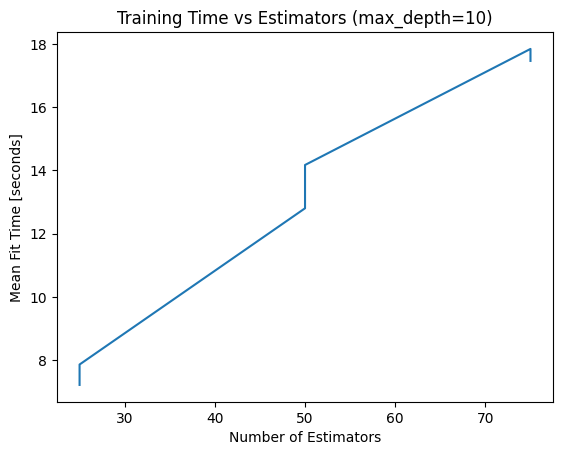

In [38]:
# Create mask
mask = cv_results["param_randomforestclassifier__max_depth"]==10
# Plot fit time vs n_estimators
plt.plot(
    cv_results[mask]["param_randomforestclassifier__n_estimators"],
    cv_results[mask]["mean_fit_time"]
)
# Label axes
plt.xlabel("Number of Estimators")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Estimators (max_depth=10)");

Create a mask for cv_results for rows where "param_randomforestclassifier__n_estimators" equals 25. Then plot "param_randomforestclassifier__max_depth" on the x-axis and "mean_fit_time" on the y-axis

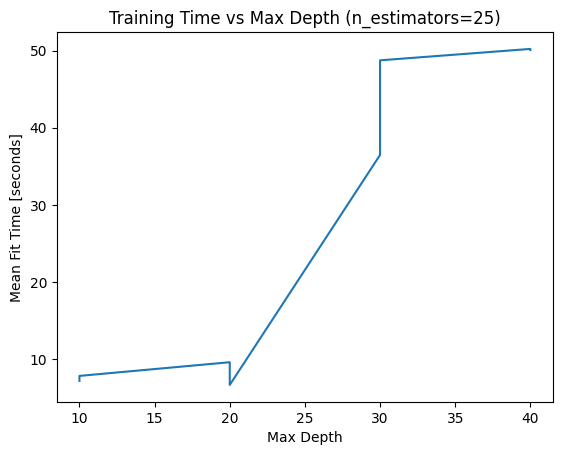

In [39]:
# Create mask
mask = cv_results["param_randomforestclassifier__n_estimators"]==25
# Plot fit time vs max_depth
plt.plot(
    cv_results[mask]["param_randomforestclassifier__max_depth"],
    cv_results[mask]["mean_fit_time"]
)
# Label axes
plt.xlabel("Max Depth")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Max Depth (n_estimators=25)");

There's a general upwards trend, but we see a lot of up-and-down here. That's because for each max depth, grid search tries two different imputation strategies: mean and median. Median is a lot faster to calculate, so that speeds up training time.

In [40]:
# Extract best hyperparameters
model.predict(X_train_over)

array([False, False, False, ...,  True,  True,  True])

### Evaluate

In [41]:
#Calculate the training and test accuracy scores for model.
acc_train = model.score(X_train,y_train)
acc_test = model.score(X_test,y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 1.0
Test Accuracy: 0.9589


In [42]:
y_test.value_counts()

False    1913
True       83
Name: bankrupt, dtype: int64

 Plot a confusion matrix that shows how your best model performs on your test set.

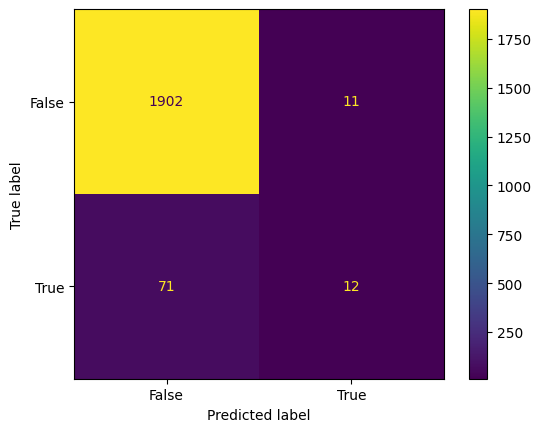

In [43]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model,X_test,y_test);

### Communicate
Create a horizontal bar chart with the 10 most important features for your model.

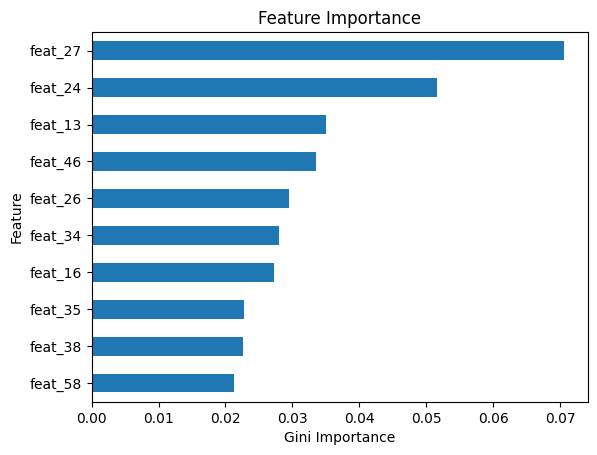

In [44]:
# Get feature names from training data
features = X_train_over.columns
# Extract importances from model
importances = model.best_estimator_.named_steps["randomforestclassifier"].feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances,index=features).sort_values()
# Plot 10 most important features
feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

## 3)Gradient Boosting Trees

In [45]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7981, 64)
y_train shape: (7981,)
X_test shape: (1996, 64)
y_test shape: (1996,)


In [46]:
##Performing Over Sampling
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over =over_sampler.fit_resample(X_train,y_train)
print(X_train_over.shape)
X_train_over.head()

(15194, 64)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64
0,0.279320,0.053105,0.852030,17.0440,199.080,0.741770,0.353570,16.00600,1.2346,0.84997,...,52857.00,0.190040,0.328630,0.80996,0.00000,NaN,4.1858,11.002,33.1760,18.5720
1,0.001871,0.735120,0.156460,1.2269,-10.837,0.000000,0.002938,0.36032,1.4809,0.26488,...,440.02,0.014794,0.007064,0.99803,0.00000,7.4268,2.2925,169.960,2.1476,9.6185
2,0.113940,0.490250,0.077121,1.2332,-43.184,-0.000171,0.113940,1.03980,1.1649,0.50975,...,4617.40,0.214890,0.223520,0.78761,0.27412,6.2791,6.1622,103.630,3.5220,1.9673
3,0.008136,0.652610,0.148120,1.2628,29.071,0.000000,0.008136,0.53230,1.2891,0.34739,...,920.98,0.045169,0.023421,0.99434,0.14403,22.7480,2.2673,159.580,2.2872,4.4718
4,0.045396,0.279640,0.708730,3.7656,238.120,0.000000,0.056710,2.57610,1.0169,0.72036,...,10744.00,0.047501,0.063019,0.94624,0.00000,13.8860,49.0660,91.984,3.9681,29.0460


Gradient boosting trees is another ensemble model. It uses a collection of tree models arranged in a sequence. Here, the model is built stage-wise; each additional tree aims to correct the previous tree's incorrect.

Where does the name gradient in gradient boosting trees come from? Gradient descent is a minimization algorithm that updates/improves the current answer by taking a step in the direction of minimizing the loss function. This is the same as the gradient boosting trees algorithm as it adds trees to minimize loss/improve model performance. The term boosting refers to the algorithm's ability to combine multiple weak models in sequence to form a stronger model.

yperparameter	Description
learning_rate	Multiplicative factor of the tree's contribution to the model.
subsample	Fraction of the training data to use when fitting the trees.
The learning rate determines how much each tree affect the final outcome and is very important in model convergence. Thus it should be considered during hyperparameter tuning to improve model performance.

 Create a pipeline named clf (short for "classifier") that contains a SimpleImputer transformer and a GradientBoostingClassifier predictor.

In [49]:
clf = make_pipeline(
   SimpleImputer(),GradientBoostingClassifier()
)

Create a dictionary with the range of hyperparameters that we want to evaluate for our classifier.

For the SimpleImputer, try both the "mean" and "median" strategies.
For the GradientBoostingClassifier, try max_depth settings between 2 and 5.
Also for the GradientBoostingClassifier, try n_estimators settings between 20 and 31, by steps of 5.

In [50]:
params ={
    "simpleimputer__strategy":["mean","median"],
    "gradientboostingclassifier__n_estimators":range(20,31,25),
    "gradientboostingclassifier__max_depth":range(2,5)
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'gradientboostingclassifier__n_estimators': range(20, 31, 25),
 'gradientboostingclassifier__max_depth': range(2, 5)}

Create a GridSearchCV named model that includes your classifier and hyperparameter grid. Be sure to use the same arguments for cv and n_jobs

In [51]:
model = GridSearchCV(clf,param_grid=params,cv=5,n_jobs=-1,verbose=1)

In [52]:
# Fit model to over-sampled training data
model.fit(X_train_over,y_train_over)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

 Extract the cross-validation results from model and load them into a DataFrame named cv_results.

In [59]:
results = pd.DataFrame(model.cv_results_)
results.sort_values("rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,39.615322,18.183683,0.010877,0.000950,4,20,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.901941,0.888450,0.884501,0.896677,0.872284,0.888771,0.010258,1
5,20.780187,0.311629,0.010803,0.000411,4,20,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.892399,0.878578,0.885160,0.879237,0.883476,0.883770,0.004980,2
2,87.717253,34.929936,0.026128,0.016179,3,20,mean,"{'gradientboostingclassifier__max_depth': 3, '...",0.848634,0.844686,0.847318,0.844357,0.853851,0.847769,0.003438,3
3,57.885761,0.670902,0.021577,0.021675,3,20,median,"{'gradientboostingclassifier__max_depth': 3, '...",0.841395,0.825930,0.828562,0.838105,0.836406,0.834079,0.005865,4
0,88.081979,1.029313,0.101576,0.104738,2,20,mean,"{'gradientboostingclassifier__max_depth': 2, '...",0.793353,0.802567,0.807832,0.790721,0.787031,0.796301,0.007720,5
1,86.800225,1.801406,0.048964,0.037178,2,20,median,"{'gradientboostingclassifier__max_depth': 2, '...",0.766700,0.751563,0.758802,0.759131,0.754444,0.758128,0.005130,6


In [60]:
# Extract best hyperparameters
model.best_params_

{'gradientboostingclassifier__max_depth': 4,
 'gradientboostingclassifier__n_estimators': 20,
 'simpleimputer__strategy': 'mean'}

### Evaluate

Calculate the training and test accuracy scores for model.

In [61]:
acc_train = model.score(X_train,y_train)
acc_test = model.score(X_test,y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Validation Accuracy:", round(acc_test, 4))

Training Accuracy: 0.8661
Validation Accuracy: 0.8417


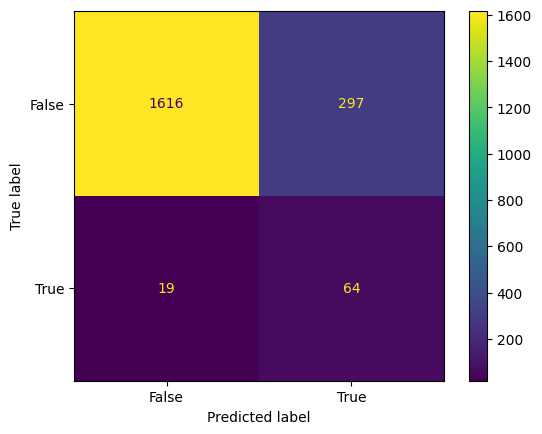

In [62]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model,X_test,y_test);

This matrix is a great reminder of how imbalanced our data is, and of why accuracy isn't always the best metric for judging whether or not a model is giving us what we want. After all, if 95% of the companies in our dataset didn't go bankrupt, all the model has to do is always predict {"bankrupt": False}, and it'll be right 95% of the time. The accuracy score will be amazing, but it won't tell us what we really need to know.

Instead, we can evaluate our model using two new metrics: precision and recall. The precision score is important when we want our model to only predict that a company will go bankrupt if its very confident in its prediction. The recall score is important if we want to make sure to identify all the companies that will go bankrupt, even if that means being incorrect sometimes.

In [65]:
# Print classification report
print(classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

       False       0.99      0.84      0.91      1913
        True       0.18      0.77      0.29        83

    accuracy                           0.84      1996
   macro avg       0.58      0.81      0.60      1996
weighted avg       0.95      0.84      0.89      1996



In [66]:
c = ConfusionMatrixWidget(model, X_test, y_test)
c.show()

FloatSlider(value=0.5, continuous_update=False, description='Threshold:', max=1.0)

If you move the probability threshold, you can see that there's a tradeoff between precision and recall. That is, as one gets better, the other suffers. As a data scientist, we'll often need to decide whether we want a model with better precision or better recall. What we choose will depend on how to intend to use your model.

Let's look at two examples, one where recall is the priority and one where precision is more important. First, let's say you work for a regulatory agency in the European Union that assists companies and investors navigate insolvency proceedings. You want to build a model to predict which companies could go bankrupt so that you can send debtors information about filing for legal protection before their company becomes insolvent. The administrative costs of sending information to a company is €500. The legal costs to the European court system if a company doesn't file for protection before bankruptcy is €50,000.

For a model like this, we want to focus on recall, because recall is all about quantity. A model that prioritizes recall will cast the widest possible net, which is the way to approach this problem. We want to send information to as many potentially-bankrupt companies as possible, because it costs a lot less to send information to a company that might not become insolvent than it does to skip a company that does.

In [67]:
c.show_eu()

FloatSlider(value=0.5, continuous_update=False, description='Threshold:', max=1.0)

For the second example, let's say we work at a private equity firm that purchases distressed businesses, improve them, and then sells them for a profit. You want to build a model to predict which companies will go bankrupt so that you can purchase them ahead of your competitors. If the firm purchases a company that is indeed insolvent, it can make a profit of €100 million or more. But if it purchases a company that isn't insolvent and can't be resold at a profit, the firm will lose €250 million.

For a model like this, we want to focus on precision. If we're trying to maximize our profit, the quality of our predictions is much more important than the quantity of our predictions. It's not a big deal if we don't catch every single insolvent company, but it's definitely a big deal if the companies we catch don't end up becoming insolvent.

```Create an interactive dashboard that shows how company profit and losses change in relationship to your model's probability threshold. Start with the make_cnf_matrix function, which should calculate and print profit/losses, and display a confusion matrix. Then create a FloatSlider thresh_widget that ranges from 0 to 1. Finally combine your function and slider in the interact function.```

In [69]:
def make_cnf_matrix(threshold):
    y_pred_proba=model.predict_proba(X_test)[:,-1]
    y_pred=y_pred_proba>threshold
    conf_matrix=confusion_matrix(y_test,y_pred)
    tn,fp,fn,tp=conf_matrix.ravel()
    print(f"Profit: €{tp*100_000_000}")
    print(f"Losses: €{fp*250_000_000}")
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred,colorbar=False)
    
thresh_widget = widgets.FloatSlider(min=0,max=1,value=0.5,step=0.05)

interact(make_cnf_matrix, threshold=thresh_widget);

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…